### Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wrds
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

In [2]:
#Setting up WRDS connection
db = wrds.Connection(wrds_username='ybhatnagar')

Loading library list...
Done


### Loading datasets

In [3]:
# 1. Sample selection
funda = db.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich, tic
	                  from compa.funda where
	                   (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear<2011 and
                       fyear>1999
                      """) 
funda

,gvkey,fyear,ni,csho,prcc_f,sich,tic
0,001004,2000.0,18.531,26.937,14.000,5080.0,AIR
1,001010,2000.0,79.900,0.015,NaN,3743.0,4165A
2,001013,2000.0,868.100,770.300,21.375,3661.0,ADCT.1
3,001019,2000.0,1.762,0.166,183.000,7380.0,AFAP
4,001021,2000.0,-0.808,9.271,0.490,3861.0,IWKS
...,...,...,...,...,...,...,...
121658,297209,2010.0,37.299,1.921,NaN,1381.0,PACDQ
121659,298079,2010.0,-0.163,0.125,NaN,1040.0,TCH.
121660,298434,2010.0,NaN,NaN,NaN,NaN,GDDLF
121661,311524,2010.0,NaN,NaN,NaN,NaN,TAM


In [4]:
company = db.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 
company

,gvkey,sic
0,001000,3089
1,001001,5812
2,001002,3825
3,001003,5712
4,001004,5080
...,...,...
50145,346933,1044
50146,347007,2836
50147,347085,7370
50148,347372,1000


In [5]:
#Merging the datasets - LEFT JOIN on funda
funda1=pd.merge(funda,company,on=['gvkey'])
funda1

,gvkey,fyear,ni,csho,prcc_f,sich,tic,sic
0,001004,2000.0,18.531,26.937,14.00,5080.0,AIR,5080
1,001004,2001.0,-58.939,31.870,11.44,5080.0,AIR,5080
2,001004,2002.0,-12.410,31.851,4.50,5080.0,AIR,5080
3,001004,2003.0,3.504,32.245,9.58,5080.0,AIR,5080
4,001004,2004.0,15.453,32.586,16.04,5080.0,AIR,5080
...,...,...,...,...,...,...,...,...
121658,287922,2010.0,5.110,43.280,NaN,NaN,BBYLF,7370
121659,290862,2010.0,-12.379,159.383,1.45,NaN,APEOF,1311
121660,296885,2010.0,-2.544,0.960,NaN,2836.0,RDHL,2836
121661,298434,2010.0,NaN,NaN,NaN,NaN,GDDLF,1040


### 1. Data Manipulation

In [6]:
#Checks for missing data and replaces it
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich'],funda1['sic']) 

funda1=funda1.drop(['sich','sic'],axis=1)
funda1['sic1']=funda1['sic1'].astype(int)

#Having a glance at the dataset
funda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121663 entries, 0 to 121662
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   gvkey   121663 non-null  object 
 1   fyear   121663 non-null  float64
 2   ni      105787 non-null  float64
 3   csho    115952 non-null  float64
 4   prcc_f  108171 non-null  float64
 5   tic     121596 non-null  object 
 6   sic1    121663 non-null  int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 7.0+ MB


#### Industry restriction -- Deleting financial institutions

In [7]:
indexNames =funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index
funda1.drop(indexNames , inplace=True)
indexNames =funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index
funda1.drop(indexNames , inplace=True)
funda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96258 entries, 0 to 121662
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gvkey   96258 non-null  object 
 1   fyear   96258 non-null  float64
 2   ni      81116 non-null  float64
 3   csho    91944 non-null  float64
 4   prcc_f  86926 non-null  float64
 5   tic     96191 non-null  object 
 6   sic1    96258 non-null  int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 5.5+ MB


### 2. Variable construction

In [8]:
funda1.describe()

,fyear,ni,csho,prcc_f,sic1
count,96258.000000,81116.000000,9.194400e+04,86926.000000,96258.000000
mean,2004.923580,98.069658,3.879001e+02,23.756261,4770.874816
std,3.193068,1142.685374,8.569755e+04,924.092679,2330.714802
min,2000.000000,-98696.000000,0.000000e+00,0.000100,100.000000
25%,2002.000000,-6.130000,9.367750e+00,1.400000,2836.000000
50%,2005.000000,0.130500,2.407750e+01,7.750000,3845.000000
75%,2008.000000,20.929500,5.772850e+01,19.720000,6794.000000
max,2010.000000,104821.000000,2.597496e+07,141600.000000,9997.000000


In [9]:
funda1['mv']=funda1['csho']*funda1['prcc_f']
funda1.head() # Note: Units for Ni: million, csho: million, 

,gvkey,fyear,ni,csho,prcc_f,tic,sic1,mv
0,001004,2000.0,18.531,26.937,14.00,AIR,5080,377.11800
1,001004,2001.0,-58.939,31.870,11.44,AIR,5080,364.59280
2,001004,2002.0,-12.410,31.851,4.50,AIR,5080,143.32950
3,001004,2003.0,3.504,32.245,9.58,AIR,5080,308.90710
4,001004,2004.0,15.453,32.586,16.04,AIR,5080,522.67944


#### Generating Variables

1. Lag variables for previous year

In [10]:
# generate lag variables
# you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag1= funda1[['gvkey','fyear','ni','mv']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1

funda1_lag1=funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})
funda1=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])
funda1.head()

,gvkey,fyear,ni,csho,prcc_f,tic,sic1,mv,ni_lag1,mv_lag1
0,001004,2000.0,18.531,26.937,14.00,AIR,5080,377.11800,NaN,NaN
1,001004,2001.0,-58.939,31.870,11.44,AIR,5080,364.59280,18.531,377.1180
2,001004,2002.0,-12.410,31.851,4.50,AIR,5080,143.32950,-58.939,364.5928
3,001004,2003.0,3.504,32.245,9.58,AIR,5080,308.90710,-12.410,143.3295
4,001004,2004.0,15.453,32.586,16.04,AIR,5080,522.67944,3.504,308.9071


2. Lag variables for year t-2

In [11]:
# generate lag variables
# you can use shift, but shift gives wrong lag variables when there are missing years. 
funda1_lag2= funda1[['gvkey','fyear','mv']].copy() 
funda1_lag2['fyear']=funda1_lag2['fyear']+2

funda1_lag2=funda1_lag2.rename(columns={'mv':'mv_lag2'})
funda1=pd.merge(funda1,funda1_lag2, how='left', on=['gvkey','fyear'])
funda1.head()

,gvkey,fyear,ni,csho,prcc_f,tic,sic1,mv,ni_lag1,mv_lag1,mv_lag2
0,001004,2000.0,18.531,26.937,14.00,AIR,5080,377.11800,NaN,NaN,NaN
1,001004,2001.0,-58.939,31.870,11.44,AIR,5080,364.59280,18.531,377.1180,NaN
2,001004,2002.0,-12.410,31.851,4.50,AIR,5080,143.32950,-58.939,364.5928,377.1180
3,001004,2003.0,3.504,32.245,9.58,AIR,5080,308.90710,-12.410,143.3295,364.5928
4,001004,2004.0,15.453,32.586,16.04,AIR,5080,522.67944,3.504,308.9071,143.3295


#### Generating test variables

In [12]:
funda1=funda1.rename(columns={'ni':'earn'})
funda1=funda1.dropna()
funda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51533 entries, 2 to 94209
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gvkey    51533 non-null  object 
 1   fyear    51533 non-null  float64
 2   earn     51533 non-null  float64
 3   csho     51533 non-null  float64
 4   prcc_f   51533 non-null  float64
 5   tic      51533 non-null  object 
 6   sic1     51533 non-null  int32  
 7   mv       51533 non-null  float64
 8   ni_lag1  51533 non-null  float64
 9   mv_lag1  51533 non-null  float64
 10  mv_lag2  51533 non-null  float64
dtypes: float64(8), int32(1), object(2)
memory usage: 4.5+ MB


In [13]:
funda1[['earn','mv_lag1','mv_lag2']].describe()

,earn,mv_lag1,mv_lag2
count,51533.000000,51533.000000,51533.000000
mean,136.889642,2643.642743,2598.942223
std,1272.526195,14102.456532,14409.088393
min,-98696.000000,0.000000,0.000000
25%,-5.283000,22.731000,22.480200
50%,0.735000,141.846800,137.876188
75%,31.546000,808.516720,765.238500
max,104821.000000,504239.580000,504239.580000


In [14]:
# winsorize before doing scales.
varlist=['earn','ni_lag1','mv_lag1','mv_lag2']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var]=np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

funda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51533 entries, 2 to 94209
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gvkey    51533 non-null  object 
 1   fyear    51533 non-null  float64
 2   earn     51533 non-null  float64
 3   csho     51533 non-null  float64
 4   prcc_f   51533 non-null  float64
 5   tic      51533 non-null  object 
 6   sic1     51533 non-null  int32  
 7   mv       51533 non-null  float64
 8   ni_lag1  51533 non-null  float64
 9   mv_lag1  51533 non-null  float64
 10  mv_lag2  51533 non-null  float64
dtypes: float64(8), int32(1), object(2)
memory usage: 4.5+ MB


### Scaling

In [15]:
funda1['earn_s']=funda1['earn']/funda1['mv_lag1'] # Scaled Earnings

funda1['earnchg'] = funda1['earn']-funda1['ni_lag1'] # Change in earnings
funda1['earnchg_s']=funda1['earnchg']/funda1['mv_lag2'] # Scaled change in earnings

df = funda1.copy() # Making a backup data

In [16]:
funda1=funda1[['gvkey','fyear','earn_s','earnchg_s']]
funda1

,gvkey,fyear,earn_s,earnchg_s
2,001004,2002.0,-0.034038,0.123380
3,001004,2003.0,0.024447,0.043649
4,001004,2004.0,0.050025,0.083367
5,001004,2005.0,0.067275,0.063806
6,001004,2006.0,0.066461,0.044955
...,...,...,...,...
93656,183276,2010.0,-0.139907,-0.125634
93868,184817,2010.0,1.484016,-32.060755
94029,185580,2010.0,0.118877,0.180863
94187,251658,2010.0,-0.017397,-0.465328


In [17]:
# winsorize again for the scaled variables. 
funda2=funda1.dropna()
funda2.describe()

,fyear,earn_s,earnchg_s
count,51533.000000,51533.000000,51533.000000
mean,2005.837696,0.474345,-0.323766
std,2.586509,70.172354,42.860481
min,2002.000000,-787.972289,-7929.344554
25%,2004.000000,-0.138367,-0.042399
50%,2006.000000,0.015119,0.006960
75%,2008.000000,0.066937,0.068917
max,2010.000000,12257.199460,1001.182384


In [18]:
varlist=['earn_s','earnchg_s']
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))

### Descriptive stats

In [19]:
destable=funda2.describe().transpose()  # pooled sample
destable

,count,mean,std,min,25%,50%,75%,max
fyear,51533.0,2005.837696,2.586509,2002.000000,2004.000000,2006.000000,2008.000000,2010.000000
earn_s,51533.0,-0.142250,0.608414,-4.151563,-0.138367,0.015119,0.066937,1.026286
earnchg_s,51533.0,0.018349,0.578541,-3.037518,-0.042399,0.006960,0.068917,2.859596


In [20]:
desearn_s=funda2.groupby('fyear')['earn_s'].describe() 
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2002.0,6342.0,-0.221507,0.727556,-4.151563,-0.214067,-0.013754,0.060444,1.026286
2003.0,6176.0,-0.200910,0.725786,-4.151563,-0.216385,0.015438,0.076490,1.026286
2004.0,6030.0,-0.100597,0.547891,-4.151563,-0.101226,0.025364,0.069924,1.026286
2005.0,5797.0,-0.080719,0.479603,-4.151563,-0.090527,0.024956,0.065716,1.026286
2006.0,5657.0,-0.090287,0.504906,-4.151563,-0.089756,0.028295,0.067647,1.026286
2007.0,5485.0,-0.097368,0.492802,-4.151563,-0.103910,0.018675,0.063252,1.026286
2008.0,5437.0,-0.145542,0.517406,-4.151563,-0.159790,-0.006965,0.053143,1.026286
2009.0,5406.0,-0.243056,0.801611,-4.151563,-0.233531,-0.004391,0.074853,1.026286
2010.0,5203.0,-0.088471,0.524527,-4.151563,-0.104910,0.029773,0.078571,1.026286


## Plotting the distribution of Annual Net income

<function matplotlib.pyplot.show(close=None, block=None)>

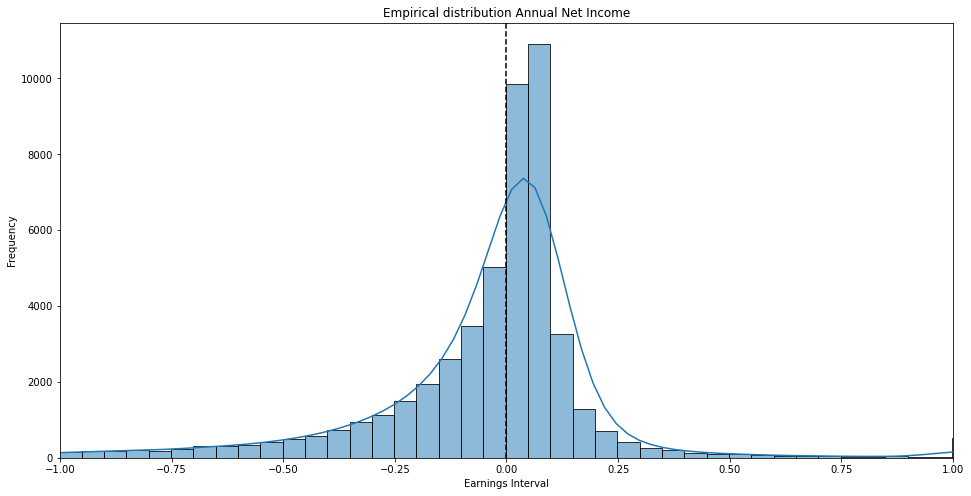

In [21]:
# Distribution figure
plt.figure(figsize=(16,8))
sns.histplot(funda2['earn_s'], binwidth = 0.05 ,kde=True) #bins = 200
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval')
plt.xlim(-1,1)
plt.ylabel('Frequency')
plt.title('Empirical distribution Annual Net Income')
plt.show

#### Plotting the frequency comparision in vicinity of 0

Text(0.5, 1.0, 'Comparison in vicinity of 0')

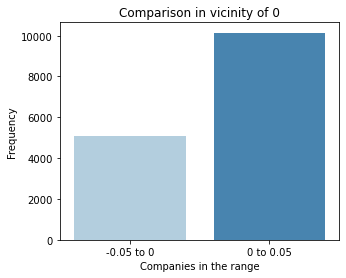

In [22]:
x1 = len(funda2[(funda2['earn_s']>=0) & (funda2['earn_s']<=0.05)])
x2 = len(funda2[(funda2['earn_s']<0) & (funda2['earn_s']>=-0.05)])

plt.figure(figsize=(5,4))
sns.barplot(x=['-0.05 to 0','0 to 0.05'], y=[x2,x1], palette='Blues')
plt.xlabel('Companies in the range')
plt.ylabel('Frequency')
plt.title('Comparison in vicinity of 0')

In [23]:
# Descriptive stats
destable2=funda2.describe().transpose()  # pooled sample
desearn_s2=funda2.groupby('fyear')['earnchg_s'].describe() 
desearn_s2

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2002.0,6342.0,0.046607,0.658328,-3.037518,-0.049913,0.008745,0.094647,2.859596
2003.0,6176.0,0.060550,0.631652,-3.037518,-0.026019,0.014609,0.105180,2.859596
2004.0,6030.0,0.004947,0.707291,-3.037518,-0.043751,0.016025,0.100100,2.859596
2005.0,5797.0,-0.002072,0.546599,-3.037518,-0.035455,0.007224,0.057104,2.859596
2006.0,5657.0,-0.010315,0.468542,-3.037518,-0.036169,0.005740,0.044841,2.859596
2007.0,5485.0,-0.026758,0.465852,-3.037518,-0.048366,0.002332,0.037300,2.859596
2008.0,5437.0,-0.043082,0.447788,-3.037518,-0.075114,-0.007101,0.027180,2.859596
2009.0,5406.0,0.030845,0.444371,-3.037518,-0.040225,0.002877,0.063586,2.859596
2010.0,5203.0,0.102021,0.707835,-3.037518,-0.029273,0.021379,0.148596,2.859596


## Plotting the distribution of Change in Annual Earnings

<function matplotlib.pyplot.show(close=None, block=None)>

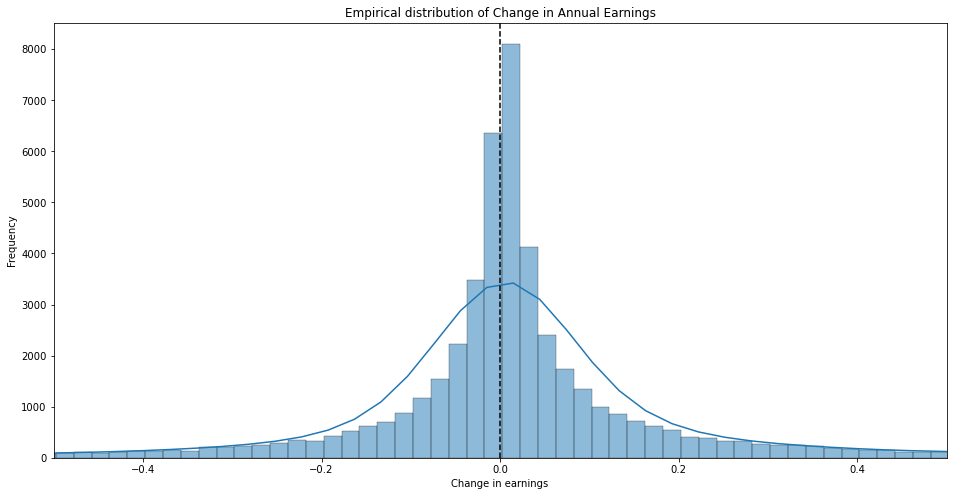

In [24]:
plt.figure(figsize=(16,8))
sns.histplot(funda2['earnchg_s'], binwidth=0.02,kde=True)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in earnings')
plt.xlim(-0.5,0.5)
plt.ylabel('Frequency')
plt.title('Empirical distribution of Change in Annual Earnings')
plt.show

In [25]:
std1 = funda2['earnchg_s'].std()
funda2['earnchg_s'].describe()

count    51533.000000
mean         0.018349
std          0.578541
min         -3.037518
25%         -0.042399
50%          0.006960
75%          0.068917
max          2.859596
Name: earnchg_s, dtype: float64

#### Plotting the frequency comparision in vicinity of 0

Text(0.5, 1.0, 'Comparison in vicinity of 0')

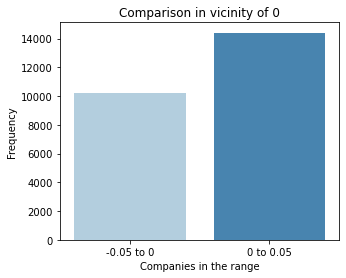

In [26]:
x1 = len(funda2[(funda2['earnchg_s']>=0) & (funda2['earnchg_s']<=0.05)])
x2 = len(funda2[(funda2['earnchg_s']<0) & (funda2['earnchg_s']>=-0.05)])

plt.figure(figsize=(5,4))
sns.barplot(x=['-0.05 to 0','0 to 0.05'], y=[x2,x1], palette='Blues')
plt.xlabel('Companies in the range')
plt.ylabel('Frequency')
plt.title('Comparison in vicinity of 0')

In [27]:
#%% Tutorial 2: Coding Exercise 1 -- Detect earnings management 
### earnings benchmark: analyst forecats
db.list_tables(library='ibes')
statsum_epsus = db.raw_sql(f"""select * from ibes.statsum_epsus where fpedats between '01/01/2000' and '01/31/2010' """, date_cols=['fpedats','statpers']) 

statsum_epsusclean=statsum_epsus.copy()

In [28]:
# focus on annual forecasts
statsum_epsusclean=statsum_epsusclean[statsum_epsusclean['fpi']=='1']
statsum_epsusclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550988 entries, 1 to 195207
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ticker       550988 non-null  object        
 1   cusip        550985 non-null  object        
 2   oftic        550889 non-null  object        
 3   cname        550985 non-null  object        
 4   statpers     550988 non-null  datetime64[ns]
 5   measure      550988 non-null  object        
 6   fiscalp      550988 non-null  object        
 7   fpi          550988 non-null  object        
 8   estflag      550988 non-null  object        
 9   curcode      550988 non-null  object        
 10  numest       550988 non-null  float64       
 11  numup        550988 non-null  float64       
 12  numdown      550988 non-null  float64       
 13  medest       550814 non-null  float64       
 14  meanest      550814 non-null  float64       
 15  stdev        432412 non-null  floa

In [29]:
# pick the most recent forecast (IBES Statistical period) from fiscal date (fpedats)

#number of days forecasted
statsum_epsusclean['day']=(statsum_epsusclean['statpers']-statsum_epsusclean['fpedats']).dt.days 

statsum_epsusclean=statsum_epsusclean[statsum_epsusclean['day']<0]

statsum_epsusclean=statsum_epsusclean.sort_values(['ticker','fpedats','day'])

statsum_epsusclean=statsum_epsusclean.drop_duplicates(['ticker','fpedats'],keep='last')

In [30]:
statsum_epsusclean['epsdiff']=statsum_epsusclean['actual']-statsum_epsusclean['medest']

In [31]:
statsum_epsusclean.head()

,ticker,cusip,oftic,cname,statpers,measure,fiscalp,fpi,estflag,curcode,...,usfirm,fpedats,actual,actdats_act,acttims_act,anndats_act,anntims_act,curr_act,day,epsdiff
3,A2,0039241X,ABY,ABITIBI CONS INC,2004-12-16,EPS,ANN,1,P,USD,...,1.0,2004-12-31,-0.250,2005-01-27,54300.0,2005-01-26,0.0,USD,-15,0.040
44,A2,0039241X,ABY,ABITIBI CONS INC,2005-12-15,EPS,ANN,1,P,USD,...,1.0,2005-12-31,-0.330,2006-02-01,37200.0,2006-02-01,26520.0,USD,-16,-0.030
105,A2,0039241X,ABY,ABITIBI CONS INC,2006-12-14,EPS,ANN,1,P,USD,...,1.0,2006-12-31,-0.390,2007-02-07,56280.0,2007-02-07,49200.0,USD,-17,0.000
179,A2,0039241X,ABY,ABITIBI CONS INC,2007-10-18,EPS,ANN,1,P,USD,...,1.0,2007-12-31,NaN,None,NaN,None,NaN,None,-74,NaN
327,AA,01381710,AA,ALCOA INC.,2000-12-14,EPS,ANN,1,P,USD,...,1.0,2000-12-31,5.445,2001-01-08,33300.0,2001-01-08,33240.0,USD,-17,-0.025


In [32]:
statsum_epsusclean.dropna(inplace=True)

# winsorize before doing scales.
varlist=['epsdiff']
for var in varlist:
    statsum_epsusclean[var] = statsum_epsusclean[var].replace(np.Inf, np.nan)
    statsum_epsusclean[var]=np.where(statsum_epsusclean[var].isnull(), np.nan, winsorize(statsum_epsusclean[var], 
                                                                                         limits=(0.01,0.01)))

statsum_epsusclean.dropna(inplace=True)
statsum_epsusclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34725 entries, 3 to 195206
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ticker       34725 non-null  object        
 1   cusip        34725 non-null  object        
 2   oftic        34725 non-null  object        
 3   cname        34725 non-null  object        
 4   statpers     34725 non-null  datetime64[ns]
 5   measure      34725 non-null  object        
 6   fiscalp      34725 non-null  object        
 7   fpi          34725 non-null  object        
 8   estflag      34725 non-null  object        
 9   curcode      34725 non-null  object        
 10  numest       34725 non-null  float64       
 11  numup        34725 non-null  float64       
 12  numdown      34725 non-null  float64       
 13  medest       34725 non-null  float64       
 14  meanest      34725 non-null  float64       
 15  stdev        34725 non-null  float64       
 16  hig

## Plotting the distribution of Meeting Analyst Forecasts

<function matplotlib.pyplot.show(close=None, block=None)>

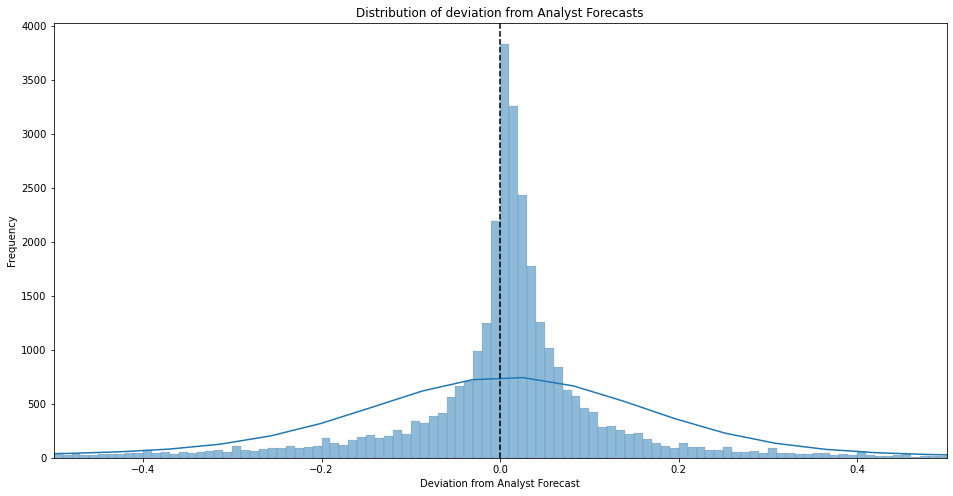

In [33]:
# Distribution figure
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,8))
sns.histplot(statsum_epsusclean['epsdiff'], binwidth=0.01,kde=True)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Deviation from Analyst Forecast')
plt.xlim(-0.5,0.5)
plt.ylabel('Frequency')
plt.title('Distribution of deviation from Analyst Forecasts')
plt.show

#### Plotting the frequency comparision in vicinity of 0

Text(0.5, 1.0, 'Comparison in vicinity of 0')

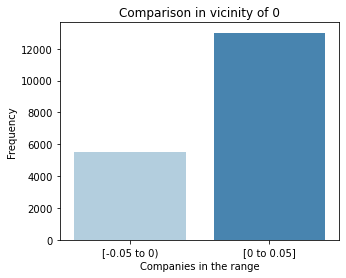

In [34]:
x1 = len(statsum_epsusclean[(statsum_epsusclean['epsdiff']>=0) & (statsum_epsusclean['epsdiff']<=0.05)])
x2 = len(statsum_epsusclean[(statsum_epsusclean['epsdiff']<0) & (statsum_epsusclean['epsdiff']>=-0.05)])

plt.figure(figsize=(5,4))
sns.barplot(x=['[-0.05 to 0)','[0 to 0.05]'], y=[x2,x1], palette='Blues')
plt.xlabel('Companies in the range')
plt.ylabel('Frequency')
plt.title('Comparison in vicinity of 0')

# Thank You!

By: Yash Bhatnagar
___